In [30]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#visualization tools
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#other tool
import numpy as np
import networkx as nx
from itertools import permutations
#quadratic program
from qiskit.optimization import QuadraticProgram
#TSP libraries
from qiskit.optimization.applications.ising import tsp
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit_optimization.applications import Maxcut, Tsp
#quantum computing optimization

# from qiskit.optimization.converters import IsingToQuadraticProgram
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo




In [31]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


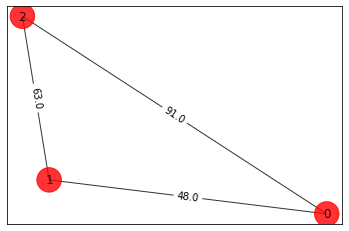

In [32]:
n = 3
num_qubits = n ** 2
ins = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(ins.graph)
print('distance\n', adj_matrix)

colors = ['r' for node in ins.graph.nodes]
pos = [ins.graph.nodes[node]['pos']  for node in ins.graph.nodes]
draw_graph(ins.graph, colors, pos)

Quantum Solution :
3
[[1. 0.]
 [2. 0.]
 [3. 0.]]
Route length:  202.0
X : [0. 0. 1. 1. 0. 0. 0. 1. 0.]
Route:  [2. 0. 1.]


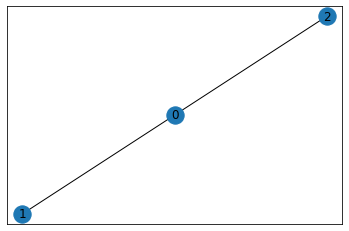

In [33]:



#function for solving the TSP with brute force, i.e. generate all permutations and calc distances
def brute_force_tsp(w):
    N = len(w)
    #generate tuples with all permutation of numbers 1,2...N-1
    #first index is zero but we want to start our travel in the first city (i.e. with index 0)
    a = list(permutations(range(1,N)))
    
    best_dist = 1e10 #distance at begining
    
    for i in a: #for all permutations
        distance = 0
        pre_j = 0 #starting in city 0
        for j in i: #for each element of a permutation
            distance = distance + w[pre_j,j] #going from one city to another
            pre_j = j #save previous city
        distance = distance + w[pre_j,0] #going back to city 0
        order = (0,) + i #route description (i is permutation, 0 at the begining - the first city)
        print('Order: ', order, ' Distance: ', distance) #show solutions
        if distance < best_dist:
            best_dist = distance
            best_order = order           
        
    print('Route length: ', best_dist)
    print('Route: ', best_order)    
    
    return best_dist, best_order

#showing resulting route in graph
def show_tsp_graph(route):
    n = len(route)
    #showing the route in graph
    G = nx.Graph() #graph
    G.add_nodes_from(range(0,n)) #add nodes
    #adding edges based on solution    
    for i in range(0,n-1):
        G.add_edge(route[i], route[i+1])
    G.add_edge(route[n-1], 0)
    nx.draw_networkx(G) #show graph

#decoding binary output of QAOA to actual solution
def decodeQAOAresults(res):
    n = int(len(res)**0.5)
    results = np.zeros(n)
    k = 0
    for i in range(0,n): #each n elements refers to one time point i
        for j in range(0,n): #in each time points there are all cities
            #when x = 1 then the city j is visited in ith time point
            if res[k] == 1: results[i] = j
            k = k + 1
    return results

def tspQuantumSolver(distances, backendName):
    citiesNumber = len(distances)
    
    print(citiesNumber)
    coordinates = np.zeros([citiesNumber, 2])
   
    for i in range(0, citiesNumber): coordinates[i][0] = i + 1
    print(coordinates)
    
    tspTask = tsp.TspData(name = 'TSP', dim = citiesNumber, w = distances, coord = coordinates)
    
    isingHamiltonian, offset = tsp.get_operator(tspTask)
    
    tspQubo = QuadraticProgram()
    tspQubo.from_ising(isingHamiltonian, offset)
    
    
    quantumProcessor = Aer.backends(name = backendName)[0]
    qaoa = MinimumEigenOptimizer(QAOA(quantum_instance = quantumProcessor))
    results = qaoa.solve(tspQubo)
    print('Route length: ', results.fval)
    print("X :", results.x)
    route = decodeQAOAresults(results.x)
    print('Route: ', route)
    
    return results.fval, route



def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]['weight'])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color='b', node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, 'weight')
    nx.draw_networkx_edge_labels(G2, pos, font_color='b', edge_labels=edge_labels)

#quantum solution
print("Quantum Solution :")
lengthQuantum, routeQuantum = tspQuantumSolver(adj_matrix, 'qasm_simulator')
show_tsp_graph(routeQuantum)
# draw_tsp_solution(ins.graph, routeQuantum, colors, pos)



Brute Force :
Order:  (0, 1, 2)  Distance:  202.0
Order:  (0, 2, 1)  Distance:  202.0
Route length:  202.0
Route:  (0, 1, 2)


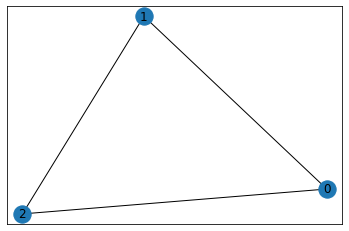

In [34]:
# brute force solution
print("Brute Force :")
lengthBrute, routeBrute = brute_force_tsp(adj_matrix)
show_tsp_graph(routeBrute)
# draw_tsp_solution(ins.graph, routeBrute, colors, pos)